In [292]:
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
import agama
from scipy.optimize import brentq
from scipy.integrate import quad
import matplotlib.cm as cm
from scipy.signal import find_peaks
from matplotlib.patches import FancyArrowPatch

In [293]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

In [294]:
# Set Agama's units: kpc, km/s, Msun
agama.setUnits(length=1, velocity=1, mass=1)

# Define the NFW potential

# Parameters for the NFW potential
Mass = 1e12  # Total mass within 5.3 scale radii in solar masses
r_s = 20.0   # Scale radius in kpc
potential = agama.Potential(type='NFW', mass=Mass, scaleRadius=r_s)

# ---------------------------------------------

# Number of radial periods
N_per = 13

# Initial conditions (orbit in X-Y plane, vz=0)
x0 = 30.0   # kpc
y0 = 0.0    # kpc
z0 = 0.0    # kpc
vx0 = -150.0 # km/s (non-zero radial velocity)
vy0 = 300.0 # km/s
vz0 = 0.0   # km/s (since orbit is in X-Y plane)

# Compute initial radius and velocity
r0 = np.sqrt(x0**2 + y0**2 + z0**2)
v0_squared = vx0**2 + vy0**2 + vz0**2

# Compute the initial energy E and angular momentum h
E = 0.5 * v0_squared + potential.potential(x0, y0, z0)
Lx = y0 * vz0 - z0 * vy0
Ly = z0 * vx0 - x0 * vz0
Lz = x0 * vy0 - y0 * vx0
h = np.sqrt(Lx**2 + Ly**2 + Lz**2)

# Function to solve radial equation for finding pericenter and apocenter
def radial_equation(r):
    phi = potential.potential(r, 0, 0)  # Spherical symmetry
    return 2 * (E - phi) - (h / r)**2

# Root solver to find pericenter (r_min) and apocenter (r_max)
r_min = brentq(radial_equation, 0.01, r0)  # Pericenter
r_max = brentq(radial_equation, r0, 100.0)  # Apocenter

# Radial period integral
def integrand_Tr(r):
    phi = potential.potential(r, 0, 0)
    return 1 / np.sqrt(2 * (E - phi) - (h / r)**2)

# Numerically integrate dt/dr to compute radial period T_r
epsilon = 1e-8
T_r, _ = quad(integrand_Tr, r_min + epsilon, r_max - epsilon)
T_r *= 2  # Multiply by 2 for full radial period

# Now integrate the orbit for 10 radial periods
tmax = N_per * T_r  # Integrate for 10 radial periods
nsteps = 1000    # Number of steps

# Integrate the orbit using AGAMA, returning an interpolator object
orbit = agama.orbit(
    potential=potential,
    ic=[x0, y0, z0, vx0, vy0, vz0],
    time=tmax,
    trajsize=nsteps,
    dtype=object,  # Return trajectory as an object
)

# Evaluate the orbit at specific times for plotting
times = np.linspace(0, tmax, nsteps)
positions = orbit(times)  # Interpolate the positions at the requested times

# Extract X and Y positions (since Z is always 0)
x = positions[:, 0]
y = positions[:, 1]

# Extract X, Y, and the radial distances
x = positions[:, 0]
y = positions[:, 1]
r = np.sqrt(x**2 + y**2)
rmax = 1.1*np.max(r)

# Find the indices of maxima (apocenters) and minima (pericenters)
maxima_indices, _ = find_peaks(r)
minima_indices, _ = find_peaks(-r)

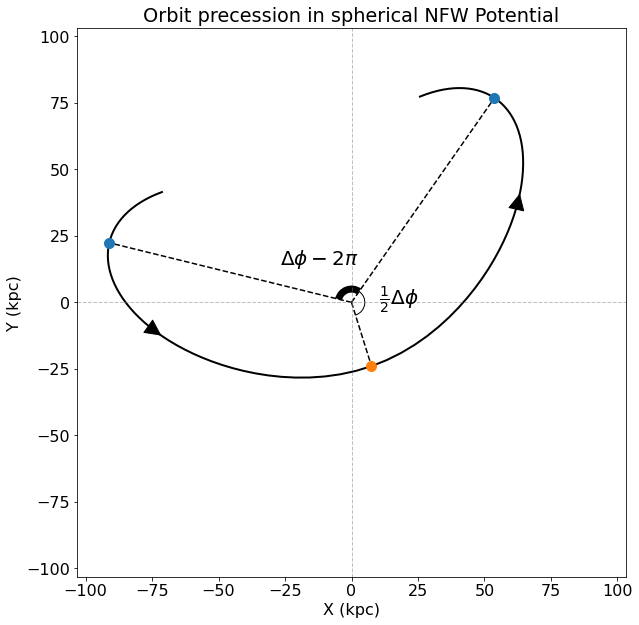

In [283]:
# Plot the X-Y projection of the orbit in black
plt.figure(figsize=(9, 9))

# Calculate the angle between the two apocenters and the X-axis
def angle_between(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    cos_theta = dot_product / norm_product
    return np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical errors

# Draw the segment from just befor first maximum to just after second maximum
nsteps_off = 15
plt.plot(x[maxima_indices[0]-nsteps_off:maxima_indices[1]+nsteps_off+1], 
         y[maxima_indices[0]-nsteps_off:maxima_indices[1]+nsteps_off+1], 
         color='black', lw=2, label='Orbit Segment')

# Set plot limits
plt.xlim(-rmax, rmax)
plt.ylim(-rmax, rmax)

# Halfway between the first maximum and the first minimum, draw an arrow
mid1 = (maxima_indices[0] + minima_indices[1]) // 2
arrow1 = FancyArrowPatch((x[mid1], y[mid1]), (x[mid1+1], y[mid1+1]), mutation_scale=30, color='black')
plt.gca().add_patch(arrow1)

# Halfway between the first minimum and the second maximum, draw another arrow
mid2 = (minima_indices[1] + maxima_indices[1]) // 2
arrow2 = FancyArrowPatch((x[mid2], y[mid2]), (x[mid2+1], y[mid2+1]), mutation_scale=30, color='black')
plt.gca().add_patch(arrow2)

# Draw lines from the origin to the first and second maxima
plt.plot([0, x[maxima_indices[0]]], [0, y[maxima_indices[0]]], 'k--')
plt.plot([0, x[maxima_indices[1]]], [0, y[maxima_indices[1]]], 'k--')

# Draw lines from the origin to the first peri
plt.plot([0, x[minima_indices[1]]], [0, y[minima_indices[1]]], 'k--')

# Mark the maxima and minima
plt.scatter(x[maxima_indices[[0,1]]], y[maxima_indices[[0,1]]], color='tab:blue', s=100, zorder=5)
plt.scatter(x[minima_indices[1]], y[minima_indices[1]], color='tab:orange', s=100, zorder=5)

# -------------
# Arc between peri and apo
# Calculate angles of the first and second maxima relative to the positive X-axis
theta2 = np.degrees(np.arctan2(y[maxima_indices[1]], x[maxima_indices[1]]))
theta1 = np.degrees(np.arctan2(y[minima_indices[1]], x[minima_indices[1]]))

# Add an arc to show the angle between the lines
arc_radius = 5.0  # Adjust the arc radius
arc = Arc((0, 0), arc_radius*2, arc_radius*2, theta1=theta1, theta2=theta2, color='black', lw=1)
plt.gca().add_patch(arc)

# Add the label near the arc
arc_label_x = arc_radius * 1.3 * np.cos(np.radians((theta1 + theta2) / 2))
arc_label_y = arc_radius * 1.3 * np.sin(np.radians((theta1 + theta2) / 2))
plt.text(arc_label_x+4, arc_label_y, r'$\frac{1}{2}\Delta \phi$', fontsize=20)

# -------------
# Arc between apo and apo
# Calculate angles of the first and second maxima relative to the positive X-axis
theta2 = np.degrees(np.arctan2(y[maxima_indices[0]], x[maxima_indices[0]]))
theta1 = np.degrees(np.arctan2(y[maxima_indices[1]], x[maxima_indices[1]]))

# Add an arc to show the angle between the lines
arc_radius = 5.0  # Adjust the arc radius
arc = Arc((0, 0), arc_radius*2, arc_radius*2, theta1=theta1, theta2=theta2, color='black', lw=7)
plt.gca().add_patch(arc)

# Add the label near the arc
arc_label_x = arc_radius * 1.0 * np.cos(np.radians((theta1 + theta2) / 2))
arc_label_y = arc_radius * 3 * np.sin(np.radians((theta1 + theta2) / 2))
plt.text(arc_label_x-25, arc_label_y, r'$\Delta \phi-2\pi$', fontsize=20)

# -------------

# Ensure square plot
plt.gca().set_aspect('equal', adjustable='box')

# Add dashed black lines for X=0 and Y=0
plt.axhline(0, color='grey', linestyle='--', lw=1, alpha=0.5)  # Y=0 line
plt.axvline(0, color='grey', linestyle='--', lw=1, alpha=0.5)  # X=0 line

# Labels and title
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.title('Orbit precession in spherical NFW Potential')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"../Figures/orbit_precession_nfw_spherical.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

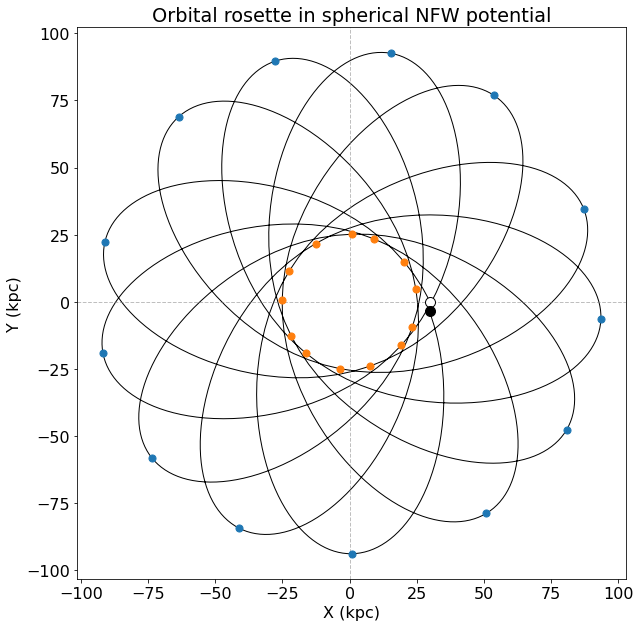

In [207]:

# Plot the X-Y projection of the orbit in black
plt.figure(figsize=(9, 9))
plt.plot(x, y, color='black', lw=1)

# Mark the beginning and end of the orbit
plt.scatter(x[0], y[0], color='white', edgecolor='black', s=100, zorder=5, label='Start')
plt.scatter(x[-1], y[-1], color='black', s=100, zorder=5, label='End')

# Mark the maxima and minima
plt.scatter(x[maxima_indices], y[maxima_indices], color='tab:blue', s=50, zorder=5)
plt.scatter(x[minima_indices], y[minima_indices], color='tab:orange', s=50, zorder=5)

# Ensure square plot
plt.gca().set_aspect('equal', adjustable='box')

# Add dashed black lines for X=0 and Y=0
plt.axhline(0, color='grey', linestyle='--', lw=1, alpha=0.5)  # Y=0 line
plt.axvline(0, color='grey', linestyle='--', lw=1, alpha=0.5)  # X=0 line

# Labels and title
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.title('Orbital rosette in spherical NFW potential')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"../Figures/orbit_rosette_nfw_spherical.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


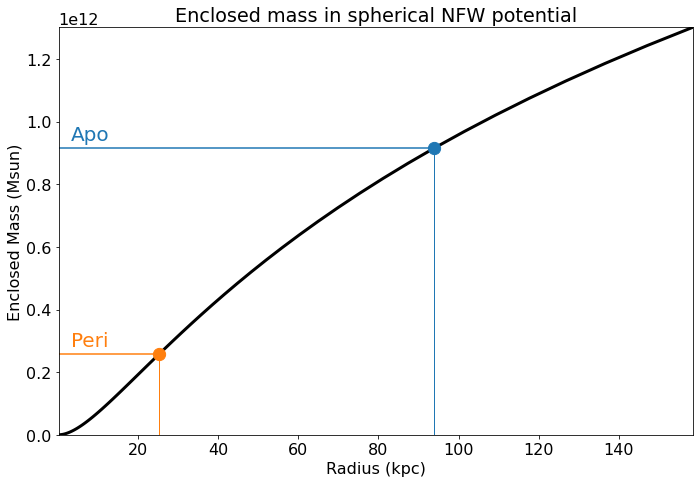

In [274]:

# Radial distances at which to compute the enclosed mass
radii = np.logspace(-1, 2.2, 100)  # Radial distances from 0.1 to 300 kpc

# Compute the enclosed mass at each radius
masses = np.array([enclosed_mass_nfw(r, Mass, r_s, r200) for r in radii])

# Function to compute enclosed mass using AGAMA
def enclosed_mass_agama(potential, r):
    return potential.enclosedMass([r, 0, 0])  # Mass enclosed within radius r

# Compute the enclosed mass at each radius using AGAMA
masses = np.array([enclosed_mass_agama(potential, r) for r in radii])

# Find the enclosed mass at the periapsis (minima) and apoapsis (maxima)
mass_at_apo = enclosed_mass_agama(potential, r[maxima_indices[0]])[0]  # Mass at apoapsis
mass_at_peri = enclosed_mass_agama(potential, r[minima_indices[0]])[0]  # Mass at periapsis

# Plot the enclosed mass as a function of radius
plt.figure(figsize=(10, 7))
plt.plot(radii, masses[:,0], label='Enclosed Mass (NFW)', color='black', lw=3)

# Lines for mass at apoapsis
plt.plot([r[maxima_indices[0]], r[maxima_indices[0]]], [0, mass_at_apo], color='tab:blue', lw=1)
plt.plot([0, r[maxima_indices[0]]], [mass_at_apo, mass_at_apo], color='tab:blue')
plt.scatter(r[maxima_indices[0]], mass_at_apo, s=150, color='tab:blue', zorder=5)

# Lines for mass at periapsis
plt.plot([r[minima_indices[0]], r[minima_indices[0]]], [0, mass_at_peri], color='tab:orange', lw=1)
plt.plot([0, r[minima_indices[0]]], [mass_at_peri, mass_at_peri], color='tab:orange')
plt.scatter(r[minima_indices[0]], mass_at_peri, s=150, color='tab:orange', zorder=5)

# Limits
plt.xlim(np.min(radii), np.max(radii))
plt.ylim(np.min(masses), np.max(masses))

# Offset in relative
xlim = plt.xlim()
ylim = plt.ylim()
x_offset = (xlim[1] - xlim[0]) * 0.02
y_offset = (ylim[1] - ylim[0]) * 0.02

# Label
plt.text(x_offset, mass_at_peri+y_offset, f'Peri', fontsize=20, color='tab:orange')
plt.text(x_offset, mass_at_apo+y_offset, f'Apo', fontsize=20, color='tab:blue')

# Labels
plt.xlabel('Radius (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.title('Enclosed mass in spherical NFW potential')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"../Figures/enclosed_mass_nfw_spherical.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


In [307]:
print(f"Period {T_r*0.97846} Gyr")

Period 1.2876880013584915 Gyr
